In this notebook I fit the microburst low Earth orbit Probability Density Function (PDF) with a variety of models. The optimizer is pymc3.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import pymc3 as pm
import theano.tensor as tt

### Define a model
First lets code up a Maxwell (Maxwell-Boltzmann) distribution.

In [21]:
def maxwell(x, a):
    """ 
    Defines a Maxwell (otherwise known as 
    Maxwell-Boltzman or Maxwellian for plasmas) 
    PDF. Independent model parameter is a. 
    The distribution is evaluated at points
    given by array x. Interesting that I did 
    not have to define theano tensor variables
    beforehand i.e. a = tt.scalar('a') and
    x = tt.vector('x') is not necessary. To see 
    values use the eval() method to return an
    array instead of a theano tensor object.
    """
    inner = -x**2/(2*a**2)
    pdf = np.sqrt(2/np.pi)*(x**2/a**3)*tt.exp(inner)
    return pdf

Now confirm that our theno representation of a Maxwell distribution is the same as other sources e.g. wikipedia.

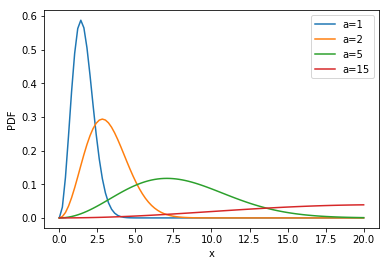

In [22]:
for a_i in [1, 2, 5, 15]:
    x = np.linspace(0, 20, num=100)
    y = maxwell(x, a_i)
    plt.plot(x, y.eval(), label=f'a={a_i}')
plt.legend()
plt.ylabel('PDF'); plt.xlabel('x');

Now lets code up a Gaussian profile

In [23]:
def gaus(x, mu, sigma):
    """ 
    Gaussian PDF written in theano. To see values
    use the eval() method to get an array back
    instead of a theano tensor object.
    """
    inner = -(x-mu)**2/(2*sigma**2)
    amplitude = tt.sqrt(2*np.pi*sigma**2)**(-1)
    pdf = amplitude*tt.exp(inner)
    return pdf

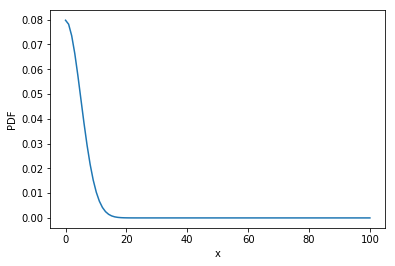

In [24]:
x = np.linspace(0, 100, num=100)
y = gaus(x, 0, 5)
plt.plot(x, y.eval())
plt.ylabel('PDF'); plt.xlabel('x');

## MCMC model

In [57]:
norm_std = 0.01

def model(x, y, dist, err=norm_std):
    """ 
    Define a pymc3 model
    """
    with pm.Model() as model:
        # Very simple model!
        if dist == maxwell:
            a = pm.Uniform('a', lower=0, upper=20)
            y_test = dist(x, a)
        elif dist == gaus:
            mu = pm.Uniform('mu', lower=0, upper=20)
            sigma = pm.Uniform('sigma', lower=0, upper=50)
            y_test = dist(x, mu, sigma)
        # Likelihood
        c_m = pm.Normal('c_m', mu=y_test, sd=err, observed=y)
        trace = pm.sample(int(1E4), tune=1000) # chains=1000, step=pm.SMC()
    return trace, c_m

### First lets fit artificial PDF to validate the model

In [26]:
a_test = 5
x = np.arange(0, 100, 5)
y = maxwell(x, a_test).eval()
y_test = np.array([np.random.normal(loc=y_i, scale=norm_std) for y_i in y])
y_test[y_test < 0] = 0

In [27]:
trace_test, c_test = model(x, y_test, maxwell)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 22000/22000 [02:46<00:00, 132.19draws/s]


Now validate the models in a few ways.

In [28]:
print(f'True a = {a_test}')

True a = 5


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,5.037643,0.235842,0.002491,4.585918,5.497499,8171.183269,1.000112


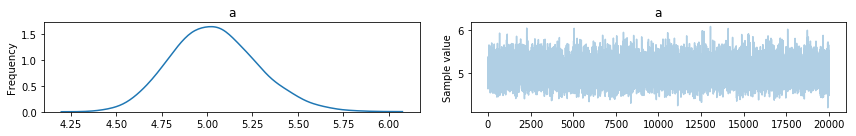

In [29]:
pm.traceplot(trace_test, combined=True);
pm.summary(trace_test)

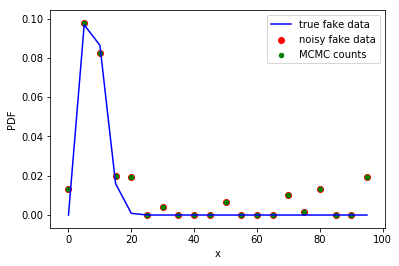

In [30]:
plt.plot(x, y, c='b', label='true fake data')
plt.scatter(x, y_test, c='r', label='noisy fake data');
plt.scatter(x, c_test.eval(), c='g', s=20, label='MCMC counts');
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF');

Now, lets load a cdf/pdf dataset that I've generated in the ./../stats/microburst_CDF.ipynb and fit a Maxwell PDF to that.

In [31]:
cdf_data = pd.read_csv('/home/mike/research/ac6_microburst_scale_sizes/data/microburst_cdf_pdf_norm_v3.csv')
cdf_data.head()

,Dist_Total,CDF,CDF_err,PDF,PDF_err
0,2.0,1.000000,0.010736,0.065418,0.009807
1,7.0,0.672909,0.028416,0.025776,0.016578
2,12.0,0.544030,0.058373,0.015706,0.015199
3,17.0,0.465501,0.026004,0.005715,0.013879
4,22.0,0.436925,0.065402,0.023021,0.012800


In [32]:
trace, c_m = model(cdf_data.Dist_Total.values, cdf_data.PDF.values, maxwell)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 22000/22000 [02:34<00:00, 142.50draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.608976,0.01226,0.00013,0.584847,0.633161,8362.323711,0.999965


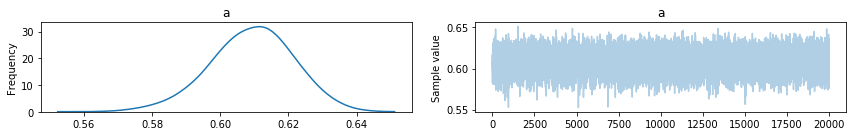

In [33]:
pm.traceplot(trace, combined=True);
pm.summary(trace)

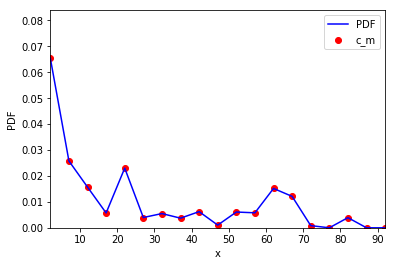

In [34]:
fig, ax = plt.subplots()
ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='r', label='c_m')
cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0);

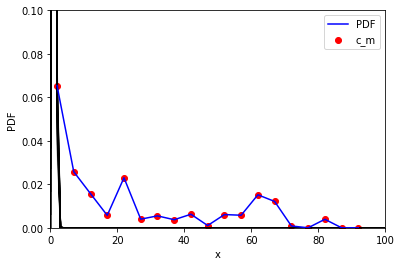

In [35]:
random_draws = np.random.choice(trace['a'], size=100)
fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, num=100)

for a_i in random_draws:
    ax.plot(x_plot, maxwell(x_plot, a_i).eval(), c='k', alpha=0.1)
ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='r', label='c_m')
cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0, top=0.1);

### Now try to fit a Gaussian PDF

In [36]:
trace_gaus, c_m = model(cdf_data.Dist_Total.values, cdf_data.PDF.values, gaus)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 22000/22000 [04:35<00:00, 43.01draws/s] 
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,1.342564,1.267379,0.014862,0.000020,3.726808,6949.569940,1.000452
sigma,7.615277,2.141359,0.029984,4.373169,11.882872,4883.801838,1.000028


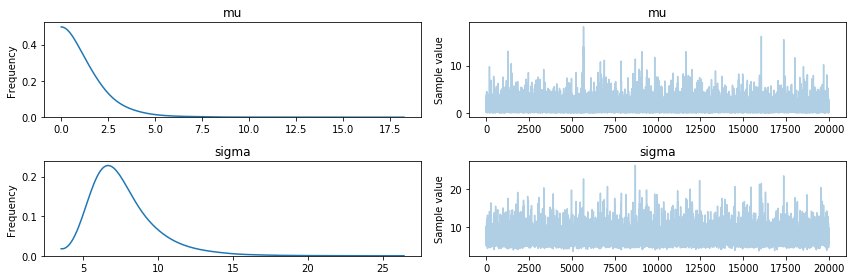

In [37]:
pm.traceplot(trace_gaus, combined=True);
pm.summary(trace_gaus)

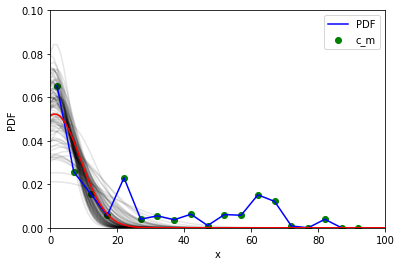

In [38]:
# Oragnize and pick 100 random pairs of mu and sigma from the fit.
gaus_params = np.array([trace_gaus['mu'], trace_gaus['sigma']]).T
random_draws = np.random.choice(np.arange(gaus_params.shape[0]), size=100)

# Find the mean set of model parameters
mean_mu = np.mean(trace_gaus['mu'])
mean_sigma = np.mean(trace_gaus['sigma'])

# Create subplot object.
fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, num=100)

# Plot the 100 random Gaussian profiles taken from the trace
for i_p in random_draws:
    ax.plot(x_plot, gaus(x_plot, *gaus_params[i_p]).eval(), c='k', alpha=0.1)
# Plot the raw data.
ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='g', label='c_m')
cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
ax.plot(x_plot, gaus(x_plot, mean_mu, mean_sigma).eval(), c='r')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0, top=0.1);

## Now lets try the same thing again, but with added uncertanity. 

In [58]:
trace_gaus_err, _ = model(cdf_data.Dist_Total.values[:-2], cdf_data.PDF.values[:-2], gaus, 
                       err=cdf_data.PDF_err.values[:-2])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 22000/22000 [04:43<00:00, 77.72draws/s] 
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


In [62]:
pm.traceplot(trace_gaus_err, combined=True);
pm.summary(trace_gaus_err)

TypeError: unhashable type: 'slice'

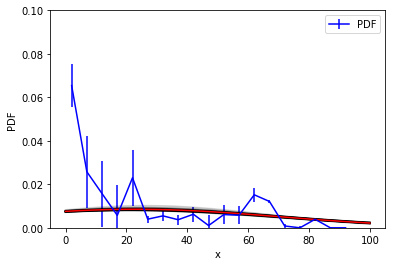

In [55]:
# Oragnize and pick 100 random pairs of mu and sigma from the fit.
gaus_params = np.array([trace_gaus_err['mu'], trace_gaus_err['sigma']]).T
random_draws = np.random.choice(np.arange(gaus_params.shape[0]), size=100)

# Find the mean set of model parameters
mean_mu = np.mean(trace_gaus_err['mu'])
mean_sigma = np.mean(trace_gaus_err['sigma'])

# Create subplot object.
fig, ax = plt.subplots()
x_plot = np.linspace(0, 100, num=100)

# Plot the 100 random Gaussian profiles taken from the trace
for i_p in random_draws:
    ax.plot(x_plot, gaus(x_plot, *gaus_params[i_p]).eval(), c='k', alpha=0.1)
# Plot the raw data.
#ax.scatter(cdf_data.Dist_Total, c_m.eval(), c='g', label='c_m')
# cdf_data.plot(x='Dist_Total', y='PDF', ax=ax, c='b')
ax.errorbar(cdf_data.Dist_Total, cdf_data.PDF, c='b', yerr=cdf_data.PDF_err)
ax.plot(x_plot, gaus(x_plot, mean_mu, mean_sigma).eval(), c='r')
plt.legend(); plt.xlabel('x'); plt.ylabel('PDF'); plt.ylim(bottom=0, top=0.1);